In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import eigs

In [2]:
class team_markov():
    
    def __init__(self):
        # read record file
        df = pd.read_csv('CFB2018_scores.csv',
                         header = None,
                         names = ['A_index', 'A_points', 'B_index', 'B_points'])
        # read team name
        self.df_team = pd.read_csv('TeamNames.txt', header = None)
        
        # markov matrix
        self.initialize(df)
        
        # eigen vector
        self.inf_state()

    def initialize(self, df):
        # initiate
        self.M = np.zeros((767,767))        
        
        # markov
        for row in range(df.shape[0]):
            i, a, j, b = df.iloc[row,:]
            i, j = i-1, j-1
            ab = a/(a+b)
            aw = int(a>b)
            self.M[i,i] += (aw + ab)
            self.M[j,j] += (1-aw + 1-ab)
            self.M[i,j] += (1-aw + 1-ab)
            self.M[j,i] += (aw + ab)
        self.M = np.divide(self.M, np.sum(self.M, axis = 1).reshape(-1,1))
        
    def inf_state(self):
        self.u, self.v = np.linalg.eig(self.M.T)
        self.w_inf = np.real(self.v[:, np.argmax(self.u)])
        self.w_inf = self.w_inf / np.sum(self.w_inf)
        
    def random_walk(self):
        # initialize w_0, uniform
        w = np.ones(767) / 767
        self.w_rec = {}
        self.w_name = {}
        self.diff = np.zeros(10000)
        
        # iterations
        for i in range(1, 10001):
            w = w.dot(self.M)
            self.diff[i-1] = np.sum(np.abs(w-self.w_inf))
            if i in [10, 100, 1000, 10000]:
                idx = np.argsort(w)[::-1][:25]
                self.w_rec[str(i)] = w[idx]
                self.w_name[str(i)] = self.df_team.iloc[idx].values.reshape(25,)

In [3]:
p1 = team_markov()

In [4]:
p1.random_walk()

In [5]:
pd.DataFrame(p1.w_rec).add_prefix('wt at t = ').to_csv('p1a1.csv')

In [6]:
pd.DataFrame(p1.w_name).add_prefix('Top 25 teams at t = ').to_csv('p1a2.csv')

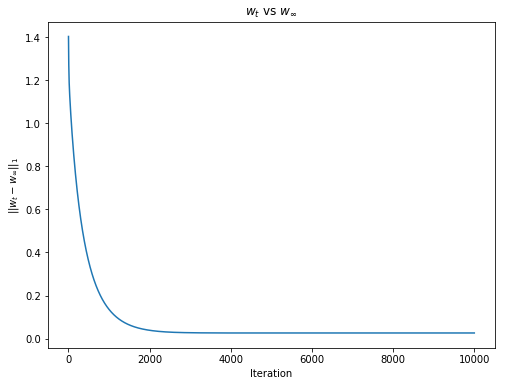

In [7]:
_ = plt.figure(figsize=(8,6))
_ = sns.lineplot(y = p1.diff, x = range(1, p1.diff.shape[0]+1))
_ = plt.title('$w_t$ vs $w_\infty$')
_ = plt.xlabel('Iteration')
_ = plt.ylabel('$||w_t - w_\infty||_1$')
_ = plt.savefig('p1b.png')